### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [14]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

We now select indices to divide the data into training, validation, and test sets.

In [16]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [17]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [18]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=1, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=50, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4913)
Training epoch 20
Error tensor(0.2234)
Training epoch 40
Error tensor(0.2151)


Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [19]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.04138256


### Part2

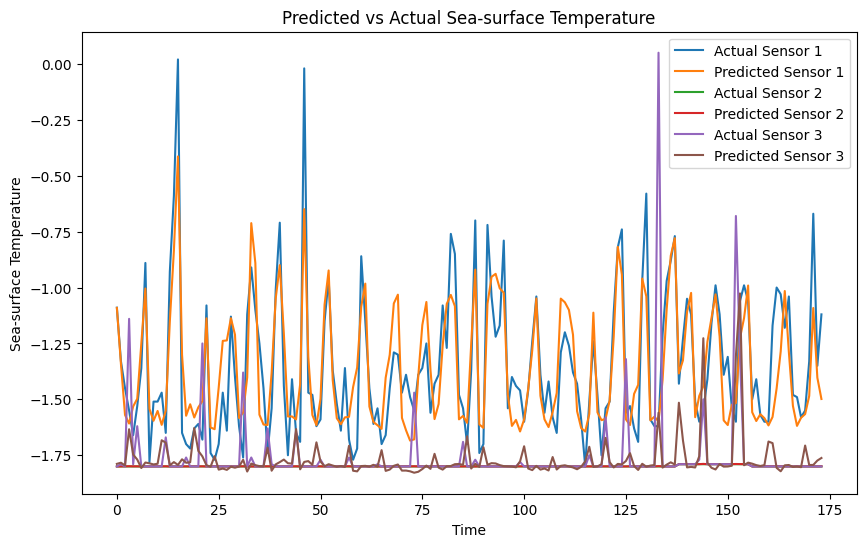

In [29]:
# Generate predictions on the test dataset if the model was trained successfully
if 'shred' in locals():
    with torch.no_grad():
        shred.eval()
        test_predictions = shred(test_dataset[:][0])

    # Inverse transform the predictions and actual values
    test_predictions = sc.inverse_transform(test_predictions.cpu().numpy())
    test_actual = sc.inverse_transform(test_dataset[:][1])

    # Plot the predicted and actual values for each sensor location
    num_sensor_locations = len(sensor_locations)
    plt.figure(figsize=(10, 6))
    for i in range(num_sensor_locations):
        plt.plot(test_actual[:, sensor_locations[i]], label=f'Actual Sensor {i+1}')
        plt.plot(test_predictions[:, sensor_locations[i]], label=f'Predicted Sensor {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Sea-surface Temperature')
    plt.title('Predicted vs Actual Sea-surface Temperature')
    plt.legend()
    plt.show()
else:
    print("The SHRED model is not available.")


### Part 3 Lag Variable

Training epoch 1
Error tensor(0.4999)
Training epoch 1
Error tensor(0.4766)
Training epoch 1
Error tensor(0.4771)
Training epoch 1
Error tensor(0.4792)
Training epoch 1
Error tensor(0.4674)
Training epoch 1
Error tensor(0.4906)


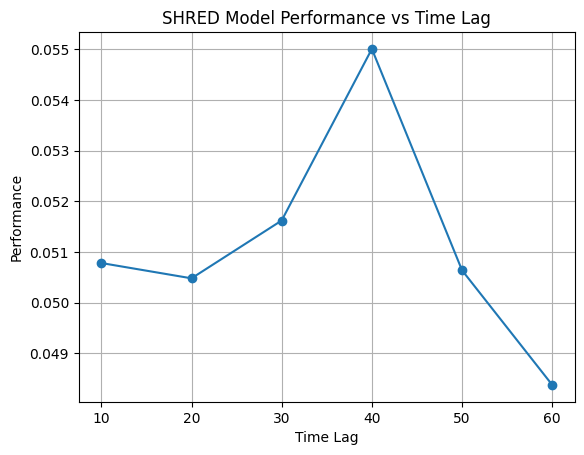

In [50]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define a list of time lag values to test
lag_values = [10, 20, 30, 40, 50, 60]

# Initialize an empty list to store the performance results
performance_results = []

# Iterate over each lag value
for lag in lag_values:
    num_sensors = 3

    # Load the data
    load_X = load_data('SST')

    # Apply the time lag to the loaded data
    load_X = load_X[lag:]

    n = load_X.shape[0]
    m = load_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lag, size=1000, replace=False)
    mask = np.ones(n - lag)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lag)[np.where(mask != 0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lag, lag, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i + lag, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lag - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lag - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lag - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=1, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(
        shred,
        train_dataset,
        valid_dataset,
        batch_size=64,
        num_epochs=10,
        lr=1e-3,
        verbose=True,
        patience=5
    )
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    performance = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    performance_results.append(performance)

# Plot the performance results
plt.plot(lag_values, performance_results, marker='o')
plt.xlabel('Time Lag')
plt.ylabel('Performance')
plt.title('SHRED Model Performance vs Time Lag')
plt.grid(True)
plt.show()



### part4 noise

Training epoch 1
Error tensor(0.4673)
Training epoch 1
Error tensor(0.4506)
Training epoch 1
Error tensor(0.4230)
Training epoch 1
Error tensor(0.4216)
Training epoch 1
Error tensor(0.4137)


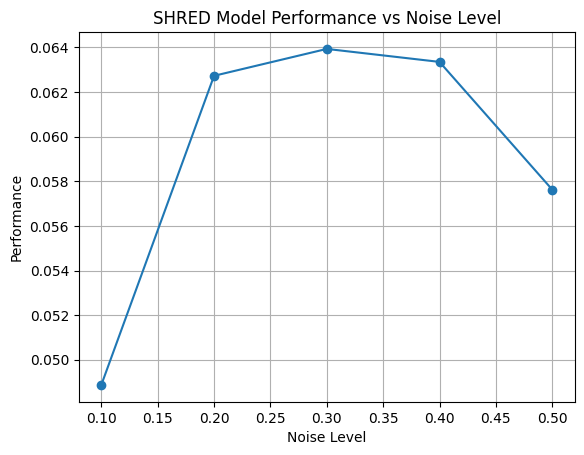

In [58]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define a list of noise levels to test
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initialize an empty list to store the performance results
performance_results = []

# Iterate over each noise level
for noise_level in noise_levels:
    num_sensors = 3
    lag = 52

    # Load the data
    load_X = load_data('SST')

    # Add negative Gaussian noise to the data
    noisy_X = load_X - np.random.normal(loc=0, scale=noise_level, size=load_X.shape)

    n = noisy_X.shape[0]
    m = noisy_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lag, size=1000, replace=False)
    mask = np.ones(n - lag)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lag)[np.where(mask != 0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(noisy_X[train_indices])
    transformed_X = sc.transform(noisy_X)

    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lag, lag, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lag, sensor_locations]

    # Generate training, validation, and test datasets
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)
    train_data_out = torch.tensor(transformed_X[train_indices + lag - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lag - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lag - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=1, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=10, lr=1e-3, verbose=True, patience=5)

    # Evaluate the model's performance on the test dataset
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    performance = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    performance_results.append(performance)

# Plot the performance results
plt.plot(noise_levels, performance_results, marker='o')
plt.xlabel('Number of sensors')
plt.ylabel('Performance')
plt.title('SHRED Model Performance vs number of sensors')
plt.grid(True)
plt.show()


### part5

Training epoch 1
Error tensor(0.4839)
Training epoch 1
Error tensor(0.4909)
Training epoch 1
Error tensor(0.4805)
Training epoch 1
Error tensor(0.4714)
Training epoch 1
Error tensor(0.4772)


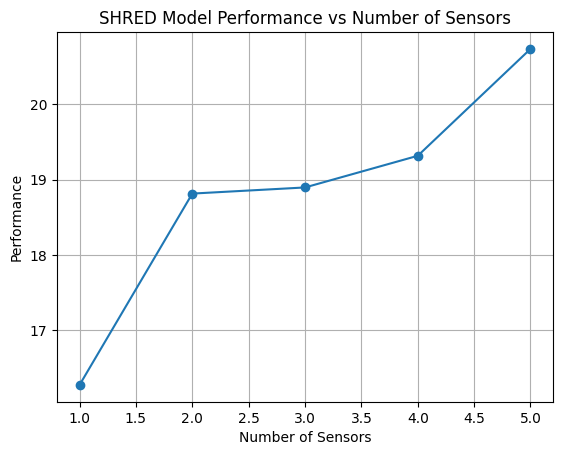

In [60]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define a list of sensor counts to test
sensor_counts = [1, 2, 3, 4, 5]

# Initialize an empty list to store the performance results
performance_results = []

# Iterate over each sensor count
for num_sensors in sensor_counts:
    lag = 52

    # Load the data
    load_X = load_data('SST')

    n = load_X.shape[0]
    m = load_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lag, size=1000, replace=False)
    mask = np.ones(n - lag)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lag)[np.where(mask != 0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lag, lag, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lag, sensor_locations]

    # Generate training, validation, and test datasets
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)
    train_data_out = torch.tensor(transformed_X[train_indices + lag - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lag - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lag - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=1, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=10, lr=1e-3, verbose=True, patience=5)

    # Evaluate the model's performance on the test dataset
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    performance = 1 / error  # Calculate performance as the inverse of the error
    performance_results.append(performance)

# Plot the performance results
plt.plot(sensor_counts, performance_results, marker='o')
plt.xlabel('Number of Sensors')
plt.ylabel('Performance')
plt.title('SHRED Model Performance vs Number of Sensors')
plt.grid(True)
plt.show()
